In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_time_series(n_series, n_steps):
    # generates series that are the sum of two sine functions (fixed amplitudes, random frequencies and phases)
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, n_series, 1)
    time = np.linspace(0,1,n_steps)
    series = 0.5*np.sin((time-offsets1)*(10*freq1+10))
    series += 0.2*np.sin((time-offsets2)*(20*freq2+20))
    series += 0.1*(np.random.randn(n_series,n_steps)-0.5)
    return series.reshape(n_series,n_steps,1)

**goal**: predict 10 time steps ahead

In [3]:
ahead = 10
n_steps = 50
n_series = 1000
series = generate_time_series(n_series=n_series, n_steps=n_steps+ahead)
series.shape

(1000, 60, 1)

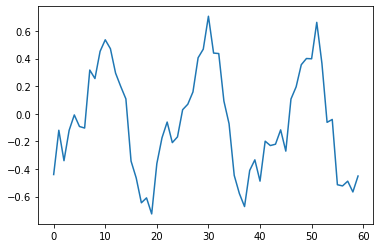

In [4]:
plt.plot(series[0])

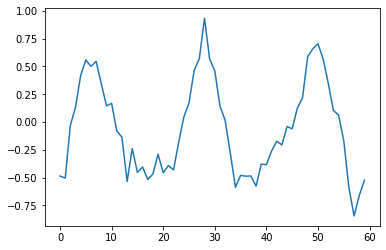

In [5]:
plt.plot(series[111])

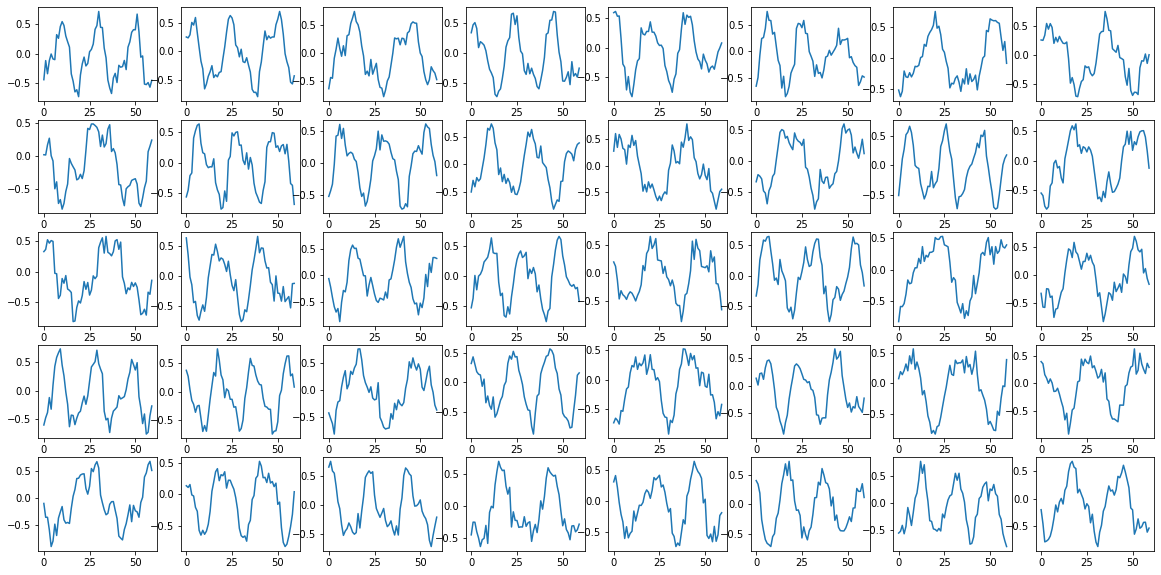

In [6]:
plt.figure(figsize=(20,10))
idx = 0
for i in range(5):
    for j in range(8):
        plt.subplot(5,8,idx+1)
        plt.plot(series[idx])
        idx+=1

## Recurrent layers

In [7]:
# recurrent layer
class recurrent_layer:
    
    
    def __init__(self,n_inputs, n_neurons): 
        
        # initialization (weights and biases)
        self.weights = 0.1*np.random.randn(n_inputs+n_neurons,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        
        # save sizes
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
        
    # forward pass: pass the data through the layer
    def forward(self, inputs1, inputs2):
        # save inputs
        self.inputs1 = inputs1
        self.inputs2 = inputs2
        self.inputs = np.c_[inputs1,inputs2]
        
        # output
        self.output = self.inputs.dot(self.weights) + self.biases
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)[:,0:self.n_inputs]
            
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        
# linear activation function: outputs = inputs
class linear:

    def forward(self, inputs):
        # flatten the output
        self.inputs = inputs
        self.output = inputs.flatten()

    def backward(self, dinputs):
        # derivative of x is 1 
        self.dinputs = dinputs.copy().reshape(-1,1) # reshape the result as a column vector
        
# mean squeared error        
class loss_mse():

    def forward(self, y_pred, y_true):

    # calculate loss
        sample_losses = (y_true - y_pred)**2
        # return losses
        return sample_losses

    def backward(self, y_pred, y_true):

        # number of data points
        samples = len(y_pred)

        # gradient 
        self.dinputs = -2 * (y_true - y_pred) 

        # normalize gradient
        self.dinputs = self.dinputs / samples
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1

In [8]:
layer1 = recurrent_layer(n_inputs=1, n_neurons=100)
activation1 = ReLU()

layer2 = recurrent_layer(n_inputs=100, n_neurons=50)
activation2 = ReLU()

layer3 = layer(n_inputs=50, n_neurons=1)
activation3 = linear()

loss = loss_mse()
optimizer = optimizer_GD(learning_rate=0.5)

In [9]:
n_epochs = 200

for epoch in range(n_epochs):
    # time step 0 - forward pass
    t = 0
    X = series[:,t,:]

    layer1.forward(X,np.zeros((len(X),100)))
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, np.zeros((len(X),50)))
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)

    losses = loss.forward(activation3.output, series[:,t+10,:].flatten())

    # time step 0 - backward pass
    loss.backward(activation3.output, series[:,t+10,:].flatten())

    activation3.backward(loss.dinputs)
    layer3.backward(activation3.dinputs)

    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)

    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    # update parameters
    #optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)
    #optimizer.post_update_parameters()

    for t in range(1,50):
        X = series[:,t,:]

        # forward
        layer1.forward(X,layer1.output)
        activation1.forward(layer1.output)

        layer2.forward(activation1.output, activation2.output)
        activation2.forward(layer2.output)

        layer3.forward(activation2.output)
        activation3.forward(layer3.output)

        losses = loss.forward(activation3.output, series[:,t+10,:].flatten())

        # backward pass
        loss.backward(activation3.output, series[:,t+10,:].flatten())

        activation3.backward(loss.dinputs)
        layer3.backward(activation3.dinputs)

        activation2.backward(layer3.dinputs)
        layer2.backward(activation2.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)

        # update parameters
        #optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer2)
        optimizer.update_parameters(layer3)
        #optimizer.post_update_parameters()

    print(np.mean(losses))

0.09757337247142263
0.07903585146961394
0.07151970288116322
0.06737185343536777
0.06559007212556793
0.06397893250228034
0.06349492188889035
0.06370824755697486
0.06767569370709225
0.06309459138204085
0.06305509506090363
0.061738745912979225
0.06195979204762639
0.06230214427529333
0.06185878904543075
0.06143806901045433
0.061958636826561615
0.06024636601319321
0.060195569120056
0.05875504856723209
0.057420035854872764
0.0568456676762345
0.05559028091893897
0.05446918779638027
0.05516307744176497
0.05492518763276226
0.05460450382283948
0.05368227367504254
0.05595678362600273
0.054012373572380014
0.05410136257814905
0.05516291684522513
0.05441204480828165
0.05249916176779384
0.050532181874861144
0.04997619004774991
0.05100946827561976
0.050061667413560884
0.050874384756528515
0.05145930522723384
0.059434804794242735
0.056326353119265336
0.06004316669591327
0.07284951488656458
0.06769320803875689
0.06464938336336579
0.0703504941171845
0.06568142109506499
0.06319978837880803
0.0678627513725

In [10]:
# forward pass
t = 0
X = series[:,t,:]
y_pred = np.zeros((1000,60))

layer1.forward(X,np.zeros((len(X),100)))
activation1.forward(layer1.output)

layer2.forward(activation1.output, np.zeros((len(X),50)))
activation2.forward(layer2.output)

layer3.forward(activation2.output)
activation3.forward(layer3.output)

y_pred[:,t] = activation3.output

for t in range(1,60):
    X = series[:,t,:]

    # forward
    layer1.forward(X,layer1.output)
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, activation2.output)
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    
    y_pred[:,t] = activation3.output

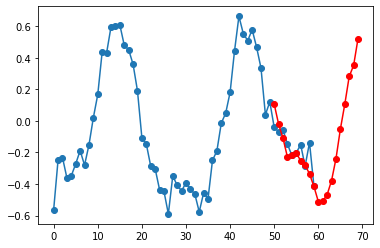

In [27]:
idx = np.random.randint(low=0,high=n_series)
plt.plot(series[idx],'-o')
plt.plot(np.arange(50,70),y_pred[idx,-20:],'-o',color='red')

## Covid cases

In [28]:
import pandas as pd

In [29]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
data = pd.read_csv(url, parse_dates=True)
data = data[data.date>'2020-06-01']
data.head()

,date,state,fips,cases,deaths
5019,2020-06-02,Alabama,1,18771,653
5020,2020-06-02,Alaska,2,497,8
5021,2020-06-02,Arizona,4,21250,943
5022,2020-06-02,Arkansas,5,7818,136
5023,2020-06-02,California,6,118081,4360


In [30]:
data.state.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
       'American Samoa'], dtype=object)

<AxesSubplot:>

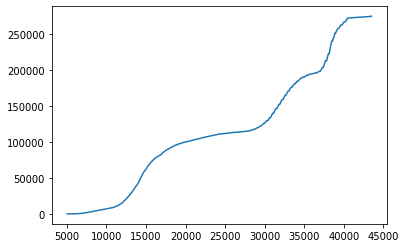

In [31]:
# cummulative cases
data[data['state']=='Montana']['cases'].plot()

<AxesSubplot:>

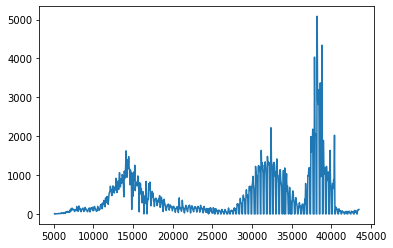

In [32]:
# daily cases
data[data['state']=='Montana']['cases'].diff().plot()

<AxesSubplot:>

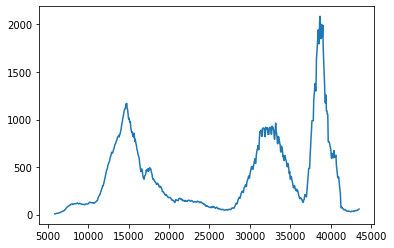

In [33]:
# 15 days average
data[data['state']=='Montana']['cases'].diff().rolling(15).mean().plot()

In [34]:
covid_data = (
      data.pivot(index='date', columns='state', values='cases')
     .drop(['Northern Mariana Islands','American Samoa'],axis=1) # too many nans
     .diff()
     .rolling(15)
     .mean()
     .dropna()
)
covid_data

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2020-06-17,569.400000,18.600000,1327.266667,385.866667,3020.000000,192.266667,163.333333,50.600000,64.066667,1684.800000,...,507.600000,2100.000000,348.466667,9.466667,0.200000,635.733333,310.800000,21.333333,462.933333,13.466667
2020-06-18,623.666667,18.600000,1432.400000,390.733333,3115.200000,189.333333,156.600000,52.466667,59.133333,1810.800000,...,505.333333,2208.733333,363.800000,9.666667,0.200000,622.200000,325.800000,22.733333,447.666667,15.266667
2020-06-19,662.000000,18.600000,1606.400000,413.733333,3195.066667,188.400000,154.533333,57.666667,55.466667,1971.000000,...,548.600000,2399.466667,381.800000,7.866667,0.200000,595.800000,336.400000,24.400000,436.933333,16.800000
2020-06-20,677.466667,18.666667,1721.933333,432.733333,3222.933333,182.200000,150.333333,60.533333,52.333333,2153.933333,...,561.600000,2551.400000,388.600000,8.000000,0.333333,594.066667,328.000000,25.400000,439.400000,16.400000
2020-06-21,665.200000,18.666667,1809.933333,430.666667,3310.666667,179.333333,129.133333,62.000000,50.066667,2302.200000,...,557.333333,2653.933333,380.066667,7.533333,0.333333,573.133333,335.333333,27.133333,440.066667,17.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-24,160.466667,188.200000,343.600000,89.333333,4080.866667,1307.400000,727.733333,152.066667,250.133333,2288.133333,...,292.600000,2217.800000,129.200000,236.200000,21.800000,1028.200000,1093.333333,92.133333,748.933333,7.400000
2022-04-25,205.733333,188.200000,343.600000,90.000000,4382.933333,1435.533333,862.800000,160.066667,250.133333,2888.466667,...,292.600000,2242.533333,129.200000,290.000000,26.000000,1248.333333,1483.600000,120.933333,940.533333,7.400000
2022-04-26,199.000000,188.200000,343.600000,101.933333,5276.600000,1335.866667,812.933333,161.066667,250.133333,2922.533333,...,360.000000,2298.533333,129.200000,254.733333,26.000000,1188.866667,1390.400000,126.800000,926.800000,17.933333


C:\Users\javier.perez-alvaro\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

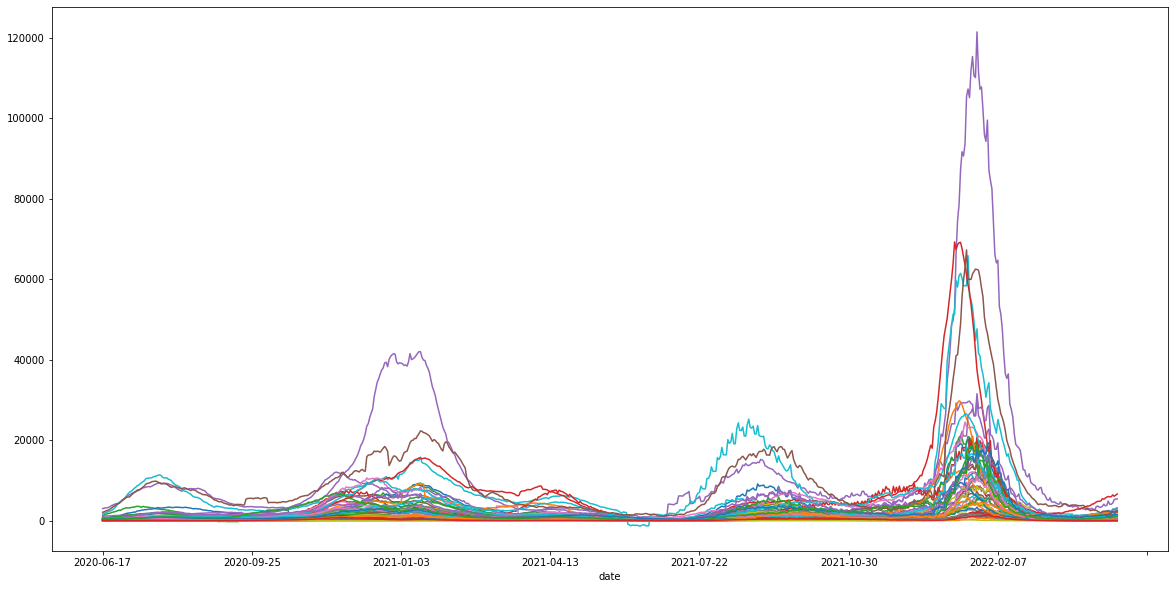

In [35]:
covid_data.plot(figsize=(20,10),legend=False)

In [36]:
# no omicron wave
covid_data = covid_data.iloc[0:550]

In [37]:
# scale each time series
maxima = covid_data.max()
minima = covid_data.min()
covid_scaled = (covid_data-minima)/(maxima-minima)

C:\Users\javier.perez-alvaro\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='date'>

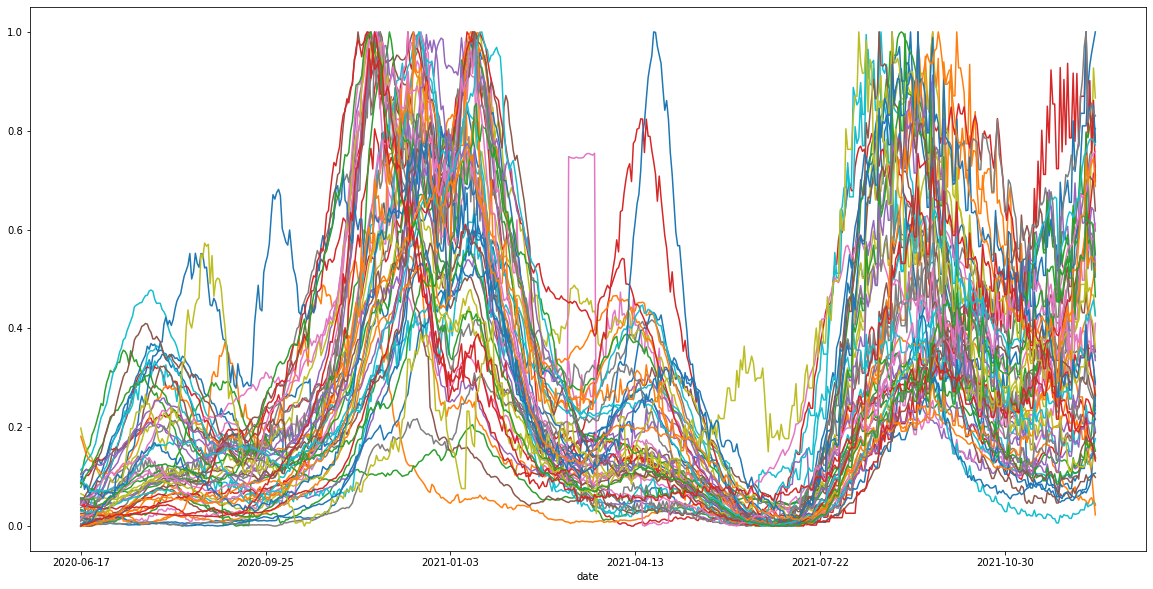

In [38]:
covid_scaled.plot(figsize=(20,10),legend=False)

In [39]:
covid_scaled.shape # 550 days

(550, 54)

In [40]:
n = 60  # window size
list_df = [] # empty list
for i in range(0,550-n):
    df = covid_scaled.T.iloc[:,i:i+n]
    df.columns = range(n)
    list_df.append(df)

In [41]:
len(list_df)

490

In [42]:
list_df[0].shape

(54, 60)

In [43]:
# number of time series
n_series = 54*490

In [44]:
series = pd.concat(list_df,ignore_index=True).to_numpy().reshape((n_series, 60, 1))
series.shape

(26460, 60, 1)

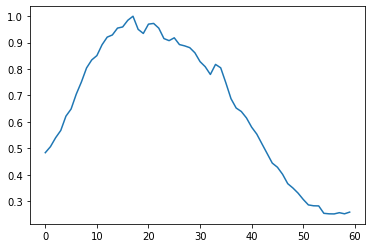

In [45]:
idx = np.random.randint(low=0,high=n_series)
plt.plot(series[idx])

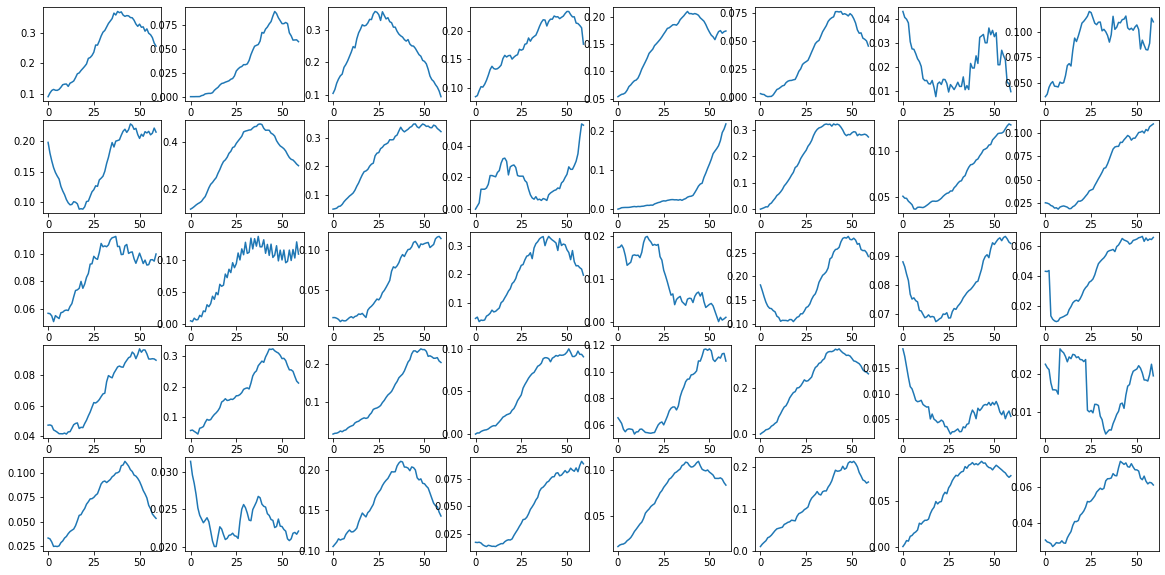

In [46]:
plt.figure(figsize=(20,10))
idx = 0
for i in range(5):
    for j in range(8):
        plt.subplot(5,8,idx+1)
        plt.plot(series[idx])
        idx+=1

In [48]:
n_series

26460

In [47]:
# reduce data size 
series = np.random.permutation(series)[0:1000]

In [49]:
layer1 = recurrent_layer(n_inputs=1, n_neurons=100)
activation1 = ReLU()

layer2 = recurrent_layer(n_inputs=100, n_neurons=100)
activation2 = ReLU()

layer3 = layer(n_inputs=100, n_neurons=1)
activation3 = linear()

loss = loss_mse()
optimizer = optimizer_GD(learning_rate=.5)
#optimizer = optimizer_ADAM(learning_rate=0.00075)

In [70]:
n_epochs = 200

for epoch in range(n_epochs):
    # time step 0 - forward pass
    t = 0
    X = series[:,t,:]

    layer1.forward(X,np.zeros((len(X),layer1.n_neurons)))
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, np.zeros((len(X),layer2.n_neurons)))
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)

    losses = loss.forward(activation3.output, series[:,t+10,:].flatten())

    # time step 0 - backward pass
    loss.backward(activation3.output, series[:,t+10,:].flatten())

    activation3.backward(loss.dinputs)
    layer3.backward(activation3.dinputs)

    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)

    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    # update parameters
    #optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)
    #optimizer.post_update_parameters()


    for t in range(1,50):
        X = series[:,t,:]

        # forward
        layer1.forward(X,layer1.output)
        activation1.forward(layer1.output)

        layer2.forward(activation1.output, activation2.output)
        activation2.forward(layer2.output)

        layer3.forward(activation2.output)
        activation3.forward(layer3.output)

        losses = loss.forward(activation3.output, series[:,t+10,:].flatten())

        # backward pass
        loss.backward(activation3.output, series[:,t+10,:].flatten())

        activation3.backward(loss.dinputs)
        layer3.backward(activation3.dinputs)

        activation2.backward(layer3.dinputs)
        layer2.backward(activation2.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)

        # update parameters
        #optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer2)
        optimizer.update_parameters(layer3)
        #optimizer.post_update_parameters()
        
    print(np.mean(losses))

0.004176392819778476
0.004153901142732885
0.004173352042708204
0.004131661326133358
0.0041173814241462926
0.004673502386976748
0.004295489460854441
0.004377885391696452
0.004155222911080797
0.004222629805140691
0.004178325291395886
0.004109769847787563
0.004149890455498245
0.004224625429003002
0.004217165317696047
0.00424832247692962
0.0077182966794495066
0.0043974895083476505
0.0047511192818840975
0.004423610407119172
0.004255086144690839
0.004188627186786094
0.004216952713819257
0.004250830236516444
0.004317952837752248
0.00465309802474445
0.0052467479764119985
0.008947571623354595
0.004453453297845201
0.0044392211452158265
0.004551913606812467
0.004442460361291871
0.004470922101866567
0.00439391101275045
0.004357244210806958
0.004407357671498343
0.004540762200920552
0.004569489303705051
0.004725496613875183
0.004985918924955845
0.004832041029760966
0.004559707260061258
0.004652446563069191
0.004537795596397814
0.004369689640225698
0.004385760032125334
0.004638118506617551
0.00463885

In [71]:
# forward pass
t = 0
X = series[:,t,:]
y_pred = np.zeros((len(X),60))

layer1.forward(X,np.zeros((len(X),layer1.n_neurons)))
activation1.forward(layer1.output)

layer2.forward(activation1.output, np.zeros((len(X),layer2.n_neurons)))
activation2.forward(layer2.output)

layer3.forward(activation2.output)
activation3.forward(layer3.output)

y_pred[:,t] = activation3.output

for t in range(1,60):
    X = series[:,t,:]

    # forward
    layer1.forward(X,layer1.output)
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, activation2.output)
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    
    y_pred[:,t] = activation3.output

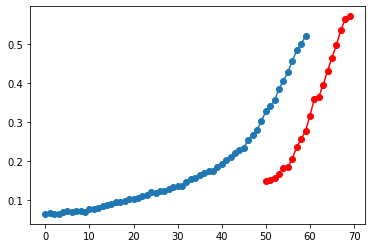

In [94]:
idx = np.random.randint(low=0,high=1000)
plt.plot(series[idx],'-o')
plt.plot(np.arange(50,70),y_pred[idx,-20:],'-o',color='red')